In [2]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import pymorphy2
import urllib.request
import json   
import requests

from scipy.sparse import hstack
from pymorphy2.tokenizers import simple_word_tokenize
from pymorphy2.shapes import is_punctuation
from collections import Counter
from stop_words import get_stop_words
from sklearn.multioutput import MultiOutputClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.preprocessing import LabelBinarizer, FunctionTransformer
from sklearn.pipeline import make_union, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin

In [3]:
df_origin = pd.read_csv("../data/itil-tickets-7.csv", sep=',')
# df_origin = df_origin.dropna()
df = df_origin.copy()

x_cols = ['title', 'user']
y_cols = ['specialist', 'category', 'analytics1', 'analytics2', 'analytics3', 'urgency', 'priority']

df['specialist'].replace(['Руководители службы Service Desk', 'Шкурупий Денис'], 'Манюхин Андрей', inplace=True)
df['specialist'].replace('Кухарчук Дмитрий', 'Сергиевич Юрий', inplace=True)
df['specialist'].replace('Талаева Вера', 'Кропис Юлия', inplace=True)
df['specialist'].replace('Быков Вадим', 'Полегошко Андрей', inplace=True)

display(df.sample(n=5).head())
display(df.shape)

,route,specialist,title,urgency,priority,category,analytics1,analytics2,analytics3,user,rejection
4045,зо,Кропис Юлия,Проверить введен ли промокод и начислено кофе ...,Средняя,Средний,Неизвестная проблема,Офистон,1С УТ 11,Поддержка УТ11,Шунько Юлия,NaN
7448,зо,Швец Богдан,нет возможности закрыть задания,Высокая,Критический,Консультация,Юридический отдел,1С УТ 11,Поддержка УТ11,Мацкевич Анастасия,NaN
12019,зо,Покровский Евгений,FW: logoton.by: Полная выгрузка картинок,Средняя,Высокий,Выгрузка данных,Отдел разработки 1С,1С УТ 11,Поддержка УТ11,Талаева Вера,NaN
14273,зи,Манюхин Андрей,Доработка: при создании новой номенклатуры сде...,Низкая,Средний,Незначительная доработка,Отдел ВЭД,1С УТ 11,Поддержка УТ11,Кропис Юлия,NaN
10204,зо,Манюхин Андрей,срочно! не формируются обособленные заказы,Высокая,Очень высокий,Неизвестная проблема,Отдел разработки 1С,1С УТ 11,Поддержка УТ11,Евхута Надежда,NaN


(16084, 11)

In [4]:
def show_distr(df, name, quantile=1):
    df_ = df.copy()
    grouped = df_[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
#     display(grouped)

    fig = plt.figure(figsize=(12, 6))
    ax = grouped.sort_values(ascending=True).plot.barh(ylim=0, title=name)
#     plt.savefig('%s.png'%(name))
#     ax.axhline(y='Email')
#     plt.plot((0, 'Email'), (3000, 'Email'), 'k-')
    plt.show()
    
def get_top(df, name, quantile=1):
    grouped = df[name].value_counts()
    grouped = grouped[grouped>=grouped.quantile(q=quantile)]
    return grouped.index.tolist()

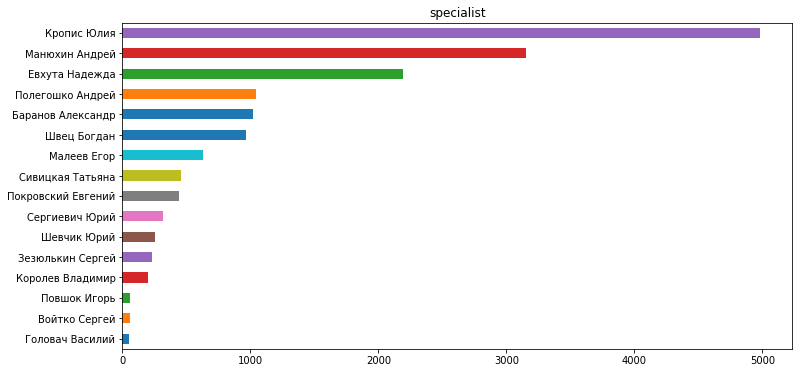

In [5]:
show_distr(df, 'specialist', 0.25)

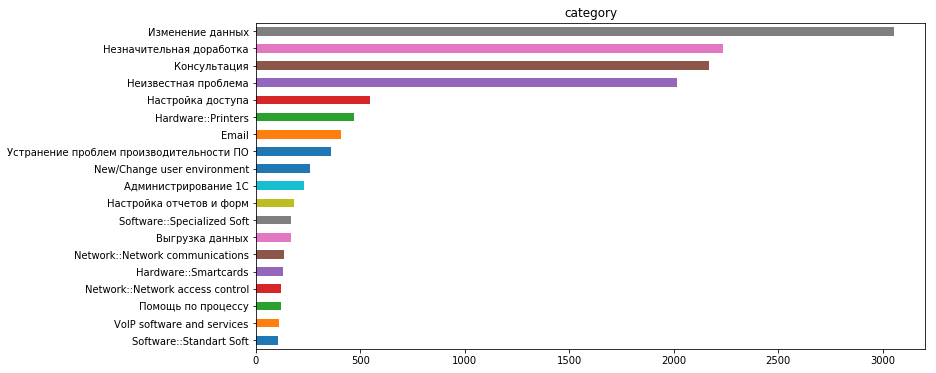

In [6]:
show_distr(df, 'category', 0.75)

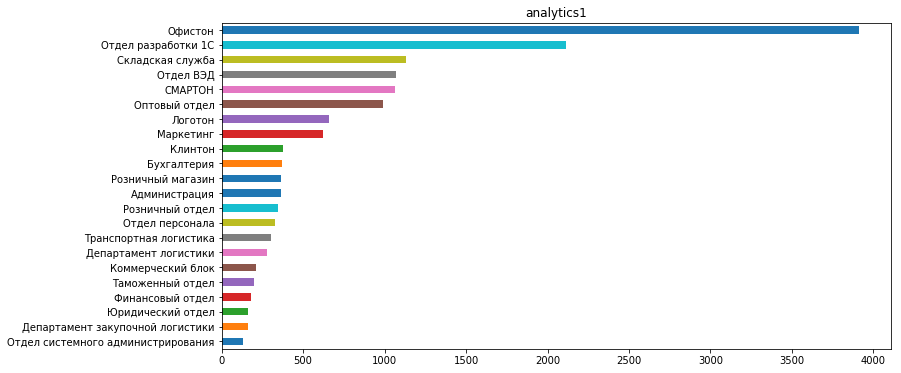

In [7]:
show_distr(df, 'analytics1', 0.50)

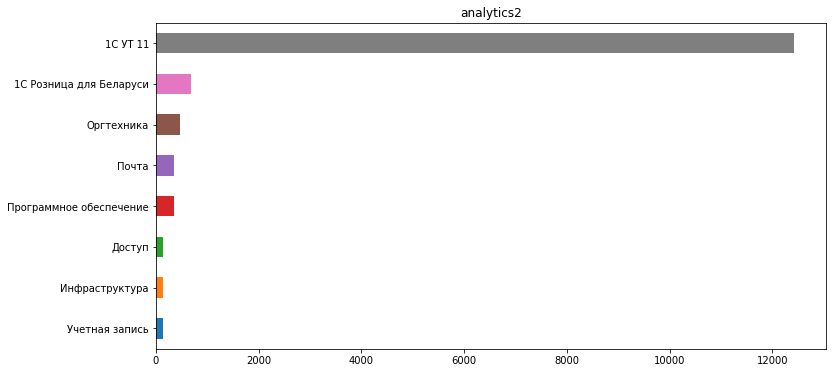

In [8]:
show_distr(df, 'analytics2', 0.85)

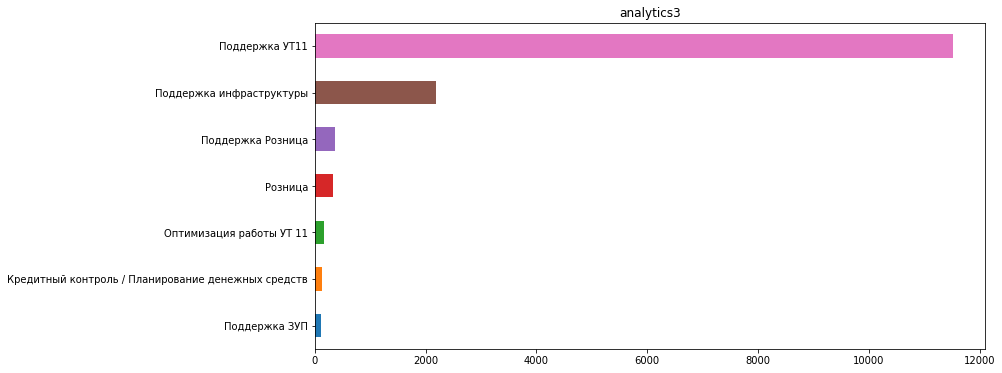

In [9]:
show_distr(df, 'analytics3', 0.85)

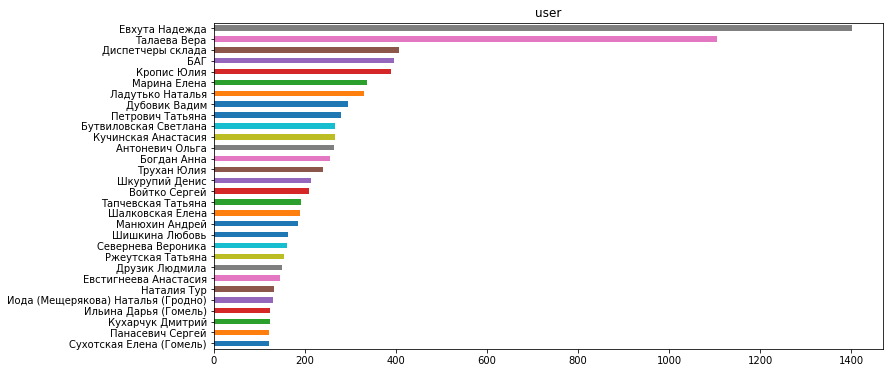

In [10]:
show_distr(df, 'user', 0.90)

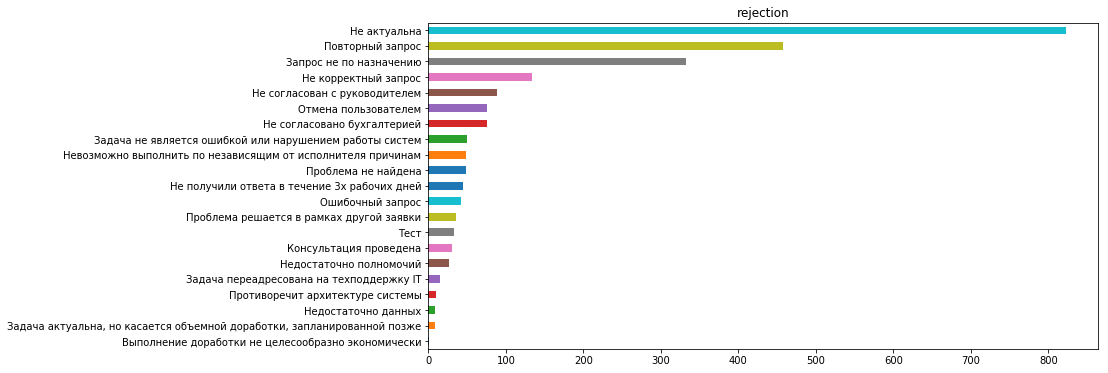

In [11]:
show_distr(df, 'rejection', 0)

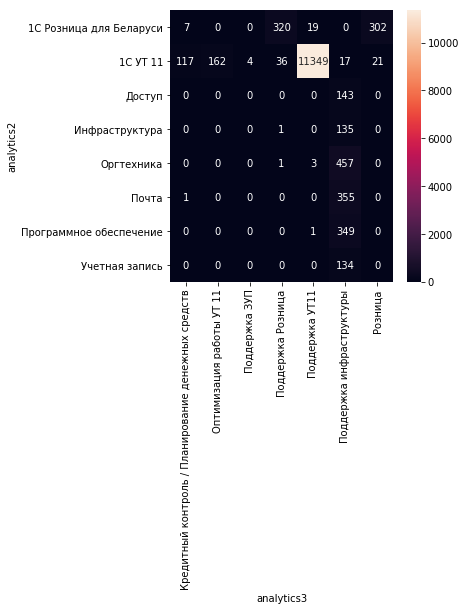

In [12]:
df_analytics = df_origin[['analytics2', 'analytics3']].copy()
analytics2_top = get_top(df_analytics, 'analytics2', 0.85)
analytics3_top = get_top(df_analytics, 'analytics3', 0.85)

df_analytics = df_analytics[df_analytics['analytics2'].isin(analytics2_top) & df_analytics['analytics3'].isin(analytics3_top)]

df_analytics_unst = df_analytics.groupby('analytics2')['analytics3'].value_counts().unstack().fillna(0)

fig, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(df_analytics_unst, annot=True, fmt="g")
plt.show()

### Elastic Search Baseline

### Preprocessing

In [13]:
def drop_below(df, name, quantile):
    top_ = get_top(df, name, quantile)
    print('%s top %d' % (name, len(top_)))
    print(df.shape[0], 'before')
    df = df[df[name].isin(top_)]
    print(df.shape[0], 'after')
    return df

In [14]:
# select top specialists
df = drop_below(df, 'specialist', 0.25)
df = drop_below(df, 'analytics1', 0.50)
df = drop_below(df, 'analytics2', 0.85)
df = drop_below(df, 'analytics3', 0.85)
df = drop_below(df, 'category', 0.75)

specialist top 16
16084 before
16056 after
analytics1 top 22
16056 before
15322 after
analytics2 top 8
15322 before
14191 after
analytics3 top 6
14191 before
13485 after
category top 18
13485 before
11323 after


In [15]:
def replace_by_re(s, pattern, repl):
    return re.sub(pattern, repl, s)

df['title'] = df['title'].apply(replace_by_re, args=('1[CСcс]', "Одинэс"))
df['title'] = df['title'].apply(replace_by_re, args=('FW:\s+', ""))
df['title'] = df['title'].apply(replace_by_re, args=('RE:\s+', ""))
# df['title'] = df['title'].apply(replace_by_re, args=('(\d{2}[\.\\\/]){2}(\d{2})+', "дата"))
df['title'] = df['title'].apply(replace_by_re, args=("[\:\#\№%\!\d\-\'\.]", ""))
# df['title'] = df['title'].apply(replace_by_re, args=('\"', ""))

# df = df[df['title']!='']
# df['title'].head()

In [16]:
morph = pymorphy2.MorphAnalyzer()
cnt = Counter()
stop_words = get_stop_words('russian')

def lemmatize(s):
    l = [morph.parse(w)[0].normal_form for w in simple_word_tokenize(s) if not is_punctuation(w)]
    l = [w for w in l if w not in stop_words]
    
    cnt.update(l)
    
    return " ".join(l)

df['title'] = df['title'].apply(lemmatize)

df['title'].head()

3                      проверка работа
15                     маленький зебра
16                 переадресация почта
17    недопровести документ реализация
18               работать ас декларант
Name: title, dtype: object

In [17]:
df_users = pd.get_dummies(df['user'])
df = pd.concat([df, df_users], axis=1)

In [18]:
# X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    df[x_cols + df_users.columns.tolist()], 
    df[y_cols], 
    df.index, 
    test_size=0.2, 
    random_state=42)

### Transform

In [19]:
labels_test = df.loc[indices_test.values][y_cols]
labels_train = df.loc[indices_train.values][y_cols]

In [20]:
class CustomBinarizer(BaseEstimator, TransformerMixin):
    transformer_ = LabelBinarizer()
       
    def __init__(self, binarizer):
        self.transformer_ = binarizer
        
    def fit(self, X, y=None):
        return self.transformer_.fit(X)
    
    def transform(self, X):
        return self.transformer_.transform(X)
        
    def fit_transform(self, X, y=None):
        return self.transformer_.fit_transform(X)
    
def get_titles(X):
    return X['title']

def get_users(X):
    return X['user']

vec = make_union(*[
    make_pipeline(FunctionTransformer(get_users, validate=False), CustomBinarizer(LabelBinarizer())),
    make_pipeline(FunctionTransformer(get_titles, validate=False), TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', ngram_range=(1, 2)))
])

features_train = vec.fit_transform(X_train)
features_test = vec.transform(X_test)
print(vec.transformer_list[1][1].steps[1][1].get_feature_names()[:20])

['abc', 'dbf', 'edi', 'editopby', 'elastalert', 'excel', 'fw', 'fwd', 'hp', 'info', 'itil', 'megacount', 'missing', 'missing value', 'outlook', 'poligon', 'poligon ref', 're', 're тикета', 'ref']


### Model Search

In [21]:
print('X_train:', X_train.shape,'X_test:', X_test.shape)
print('features_test:', features_train.shape, 'features_test:', features_test.shape)

X_train: (9058, 256) X_test: (2265, 256)
features_test: (9058, 1809) features_test: (2265, 1809)


In [22]:
model = MultinomialNB()

multi_target_nb = MultiOutputClassifier(model, n_jobs=-1)
multi_target_nb.fit(features_train, labels_train)

labels_pred = multi_target_nb.predict(features_test)
nb_classes = multi_target_nb.estimators_[0].classes_

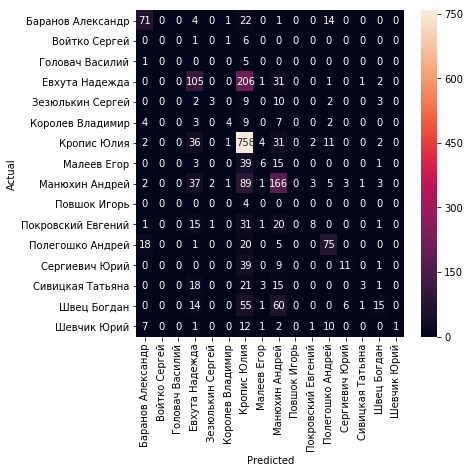

In [23]:
conf_mat = metrics.confusion_matrix(labels_test['specialist'], labels_pred[:, 0], labels=nb_classes)
fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(conf_mat, 
            annot=True, 
            fmt='g',
            xticklabels=multi_target_nb.estimators_[0].classes_,
            yticklabels=multi_target_nb.estimators_[0].classes_
           )

plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()
# plt.savefig('heatmap.png')

In [24]:
print(metrics.classification_report(labels_test['specialist'], labels_pred[:, 0], target_names=nb_classes))

                    precision    recall  f1-score   support

 Баранов Александр       0.67      0.63      0.65       113
     Войтко Сергей       0.00      0.00      0.00         8
   Головач Василий       0.00      0.00      0.00         6
    Евхута Надежда       0.44      0.30      0.36       347
  Зезюлькин Сергей       0.50      0.10      0.17        29
  Королев Владимир       0.50      0.14      0.22        29
       Кропис Юлия       0.57      0.89      0.70       847
       Малеев Егор       0.33      0.09      0.15        64
    Манюхин Андрей       0.45      0.53      0.48       313
      Повшок Игорь       0.00      0.00      0.00         4
Покровский Евгений       0.57      0.10      0.17        78
  Полегошко Андрей       0.62      0.63      0.63       119
    Сергиевич Юрий       0.55      0.18      0.27        60
  Сивицкая Татьяна       0.50      0.05      0.09        61
       Швец Богдан       0.52      0.10      0.17       152
       Шевчик Юрий       1.00      0.03

C:\Users\pokrovskiye\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Retrain on full data

In [25]:
def proba_to_classes(pred_prob_valid, multi_target_nb):
    d = {"prediction":dict()}
    
    for i in range(len(multi_target_nb.estimators_)):
        indmax = np.argmax(pred_prob_valid[i])
        try:
            d["prediction"][y_cols[i]] = {
                multi_target_nb.estimators_[i].classes_[indmax]: pred_prob_valid[i][0][indmax]}
        except:
            print("indmax: %d i: %d" % (i, indmax))
    
    return d

In [26]:
features = vec.fit_transform(df).toarray()

labels = df[y_cols]

model = MultinomialNB()
multi_target_nb = MultiOutputClassifier(model, n_jobs=-1)
multi_target_nb.fit(features, labels)

MultiOutputClassifier(estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
           n_jobs=-1)

In [27]:
X_valid = pd.DataFrame(data={"title":["не проводится ТТН"], "user":["Диспетчеры склада"]})

features_valid = vec.transform(X_valid)
# features_valid[0].reshape(1, -1)
pred_valid = multi_target_nb.predict(features_valid)
pred_prob_valid = multi_target_nb.predict_proba(features_valid)

d = proba_to_classes(pred_prob_valid, multi_target_nb)
d

{'prediction': {'specialist': {'Кропис Юлия': 0.70901383555134},
  'category': {'Изменение данных': 0.6524385296449959},
  'analytics1': {'Складская служба': 0.992100332937534},
  'analytics2': {'1С УТ 11': 0.9655382433723521},
  'analytics3': {'Поддержка УТ11': 0.9598554037983689},
  'urgency': {'Средняя': 0.3708173890651701},
  'priority': {'Очень высокий': 0.4813831532626718}}}

In [28]:
df_ngrams = pd.DataFrame(columns=['specialist', 'unigrams', 'bigrams'])

N = 2
tfidf_feature_names = vec.transformer_list[1][1].steps[1][1].get_feature_names()
binarizer_feature_names = vec.transformer_list[0][1].steps[1][1].transformer_.classes_.tolist()
full_feature_names = binarizer_feature_names + tfidf_feature_names

for specialist_id, specialist in enumerate(multi_target_nb.estimators_[0].classes_):
    indices = np.argsort(multi_target_nb.estimators_[0].coef_[specialist_id])
    
    # select only tfidf indices
    indices = indices[indices>len(indices)-len(tfidf_feature_names)]
    
    feature_names = np.array(full_feature_names)[indices]
    unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
    bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]

    df_ngrams = df_ngrams.append({
        'specialist':specialist,
        'unigrams':', '.join(unigrams),
        'bigrams':', '.join(bigrams)
    }, ignore_index=True)

df_ngrams

,specialist,unigrams,bigrams
0,Баранов Александр,"переадресация, картридж","переадресация почта, замена картридж"
1,Войтко Сергей,"сотрудник, новый","новый сотрудник, доступ одинэса"
2,Головач Василий,"сайт, белкантон","сайт белкантон, товар сайт"
3,Евхута Надежда,"подарок, база","розница оргвопрос, висеть база"
4,Зезюлькин Сергей,"одинэса, база","missing value, база одинэса"
5,Королев Владимир,"доступ, новый","учётный запись, новый сотрудник"
6,Кропис Юлия,"база, реализация","висеть база, зона доставка"
7,Малеев Егор,"себестоимость, оплата","одинэса ут, гтд москва"
8,Манюхин Андрей,"заказ, отчёт","печатный форма, заказ клиент"
9,Повшок Игорь,"сайт, регистрация","отображаться сайт, почтовый ящик"


### Dump and Load check

In [28]:
joblib.dump(multi_target_nb, '../static/itil-multitarget.pkl')
joblib.dump(multi_target_nb.estimators_[0], '../static/itil-multinb.pkl')
joblib.dump(vec, '../static/itil-transformer.pkl')

['../static/itil-transformer.pkl']

In [113]:
j = '''[
    {"id":1, "title":"не проводится ТТН", "user":"Диспетчеры склада"},
    {"id":2, "title":"1СРозница - отображение цены", "user":"Дубовик Вадим"}  
]'''

df_valid = pd.read_json(j)

#                                     
                                       
clf = joblib.load('../static/itil-multitarget.pkl')
transformer = joblib.load('../static/itil-transformer.pkl')

features = vec.transform(df_valid)
prediction = multi_target_nb.predict_proba(features)

In [114]:
response_data = []

for j in range(len(df_valid)):
    response_row = {"id": df_valid.at[j, "id"], "prediction": dict()}
    
    for i in range(len(multi_target_nb.estimators_)):
    
        indmax = np.argmax(prediction[i][j])
        try:
            response_row["prediction"][y_cols[i]] = {
                multi_target_nb.estimators_[i].classes_[indmax]: prediction[i][j][indmax]}
        except:
            print("indmax: %d i: %d" % (i, indmax))
            
    response_data.append(response_row)
    
response_data    

[{'id': 1,
  'prediction': {'specialist': {'Кропис Юлия': 0.70901383555134},
   'category': {'Изменение данных': 0.6524385296449959},
   'analytics1': {'Складская служба': 0.992100332937534},
   'analytics2': {'1С УТ 11': 0.9655382433723521},
   'analytics3': {'Поддержка УТ11': 0.9598554037983689},
   'urgency': {'Средняя': 0.3708173890651701},
   'priority': {'Очень высокий': 0.4813831532626718}}},
 {'id': 2,
  'prediction': {'specialist': {'Евхута Надежда': 0.23499372015641085},
   'category': {'Консультация': 0.4054103790535161},
   'analytics1': {'Розничный магазин': 0.9285807711207041},
   'analytics2': {'1С Розница для Беларуси': 0.9429667188351043},
   'analytics3': {'Поддержка Розница': 0.780123475838407},
   'urgency': {'Низкая': 0.644695272145829},
   'priority': {'Средний': 0.41855880102562176}}}]

# doc2vec

In [ ]:
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from gensim.utils import simple_preprocess

In [ ]:
def tag_docs(docs, col, label): 
    tagged = docs.apply(lambda r: TaggedDocument(words=simple_preprocess(r[col]), tags=[r[label]]),  axis=1) 
    return tagged

def train_doc2vec_model(tagged_docs): 
    sents = tagged_docs.values
    doc2vec_model = Doc2Vec(sents, epochs=20, dm=1) #size=size, window=window, 
    return doc2vec_model

def vec_for_learning(doc2vec_model, tagged_docs):
    sents = tagged_docs.values 
    targets, regressors =  zip(*[(doc.tags[0], doc2vec_model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors

In [ ]:
train_tagged = tag_docs(train_data, 'title', 'specialist')
test_tagged = tag_docs(test_data, 'title', 'specialist')
model = train_doc2vec_model(train_tagged)

In [ ]:
y_train, X_train = vec_for_learning(model, train_tagged)
y_test, X_test = vec_for_learning(model, test_tagged)
logreg = LogisticRegression()
logreg.fit(X_train, y_train) 
y_pred = logreg.predict(X_test)

In [ ]:
print(metrics.classification_report(y_test, y_pred, target_names=df['specialist'].unique()))